In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit
import os

# Averaging chaotic trajectories over model runs

This notebook repeats the computation of divergence between two trajectories with nearby initial conditions over 10 model runs.

The resulting set of $|d(t)|$ curves is averaged, the chaotic window determined, and an exponential curve is fit to find an estimated Lyapunov exponent for the delta.

## Prerequisites:

We need the base trajectory \(eta\_base\) and a directory of perturbed trajectories  \(eta\_perturbed\) from chaos\_runs.m in the directory of this notebook. chaos\_runs.m needs the chaotic_base workspace for setting parameters for a chaotic delta.


In [2]:
eta_base = scipy.io.loadmat('eta_base.mat')['eta_save']
eta_base.shape

(7, 4000)

In [3]:
eta_comps = []

for file in os.listdir('eta_perturbed'):
    eta_comps.append(scipy.io.loadmat(f'eta_perturbed/{file}')['eta_save'])

f'{len(eta_comps)} perturbed trajectories loaded'

'30 perturbed trajectories loaded'

Finding $|d|$ time series by summing absolute values of bed elevation differences at each node

$ |d(t)|=  \sum_{j=1}^6  |\eta^{pert}_j - \eta^{base}_j |$

In [4]:
ds = []
for eta_comp in eta_comps:
    d = []
    for t in range(eta_comp.shape[1]):
        d_j = 0
        for j in range(6):
            d_j += np.abs(eta_comp[j+1][t] - eta_base[j+1][t])
        d.append(d_j)

    d = np.array(d)
    ds.append(d)
len(ds)

30

In [5]:
times = scipy.io.loadmat('eta_base.mat')['t_save'][0]
times.shape

(4000,)

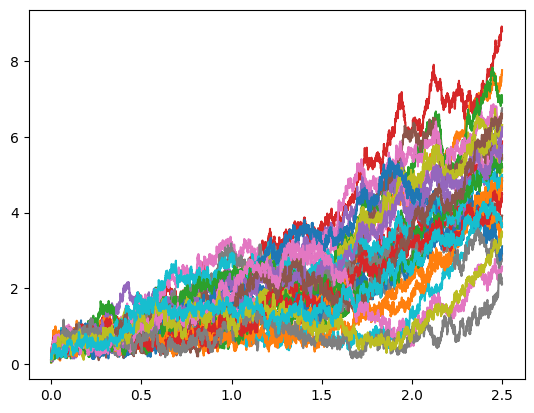

In [6]:
for d in ds:
    plt.plot(times, d)

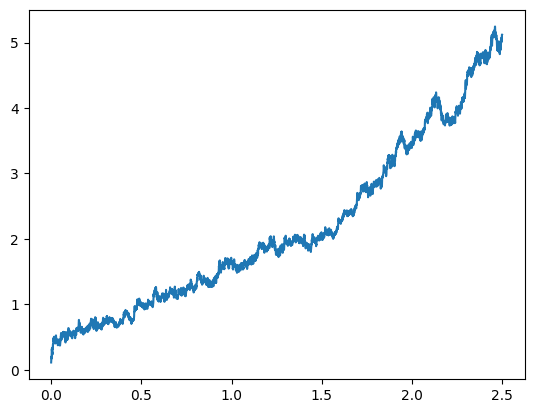

In [7]:
d_average = []
for t in range(eta_comp.shape[1]):
    d_average.append(np.average(np.array(ds)[:,t]))
d_average = np.array(d_average)
plt.plot(times, d_average)

## Curve Fitting



In [8]:
# General exponential function
def f(t,k, d_0, t_0):
    return d_0*np.exp(k*(t-t_0))

### Finding chaotic window

Iterates over a range of reasonable lower and upper bound combinations, curve fits, and selects the one with the best $r^2$.

In [9]:
lower_bounds = np.linspace(0, 1000, 10)
upper_bounds = np.linspace(3000,4000,10)

best_lower_bound = 0
best_upper_bound= 4000
best_bounds_r_squared = 0

for lower_bound in lower_bounds:
    for upper_bound in upper_bounds:
        
        lower_bound = int(lower_bound)
        upper_bound = int(upper_bound)
        
        if upper_bound > lower_bound:
            d_average_truncated = np.copy(d_average)[lower_bound:upper_bound]
            times_truncated = np.copy(times)[lower_bound:upper_bound]
            
            popt, pcov = curve_fit(lambda t, b: d_average_truncated[0] * np.exp(b * (t-times_truncated[0])),  times_truncated, d_average_truncated)

            residuals = np.sum((d_average_truncated - f(times_truncated, popt[0], d_average_truncated[0], times_truncated[0]))**2)

            sum_squares = np.sum((d_average_truncated - np.mean(d_average_truncated))**2)

            r_squared = 1 - (residuals / sum_squares)

            if 1-r_squared < 1-best_bounds_r_squared:
                best_bounds_r_squared = r_squared
                best_lower_bound = lower_bound
                best_upper_bound = upper_bound
                
                
        
d_average = d_average[best_lower_bound : best_upper_bound]
times = times[best_lower_bound : best_upper_bound]

In [10]:
popt, pcov = curve_fit(lambda t, b: d_average[0] * np.exp(b * (t-times[0])), times, d_average)

In [11]:
residuals = np.sum((d_average - f(times,popt[0], d_average[0], times[0]))**2)

sum_squares = np.sum((d_average-np.mean(d_average))**2)

r_squared = 1 - (residuals / sum_squares)

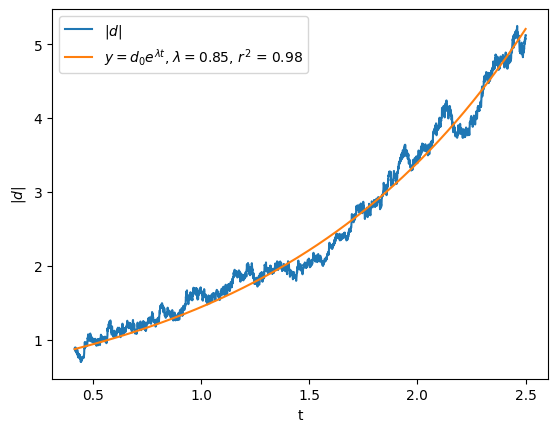

In [12]:
plt.figure()
plt.plot(times, d_average)
plt.plot(times, f(times, popt[0], d_average[0], times[0]))
plt.xlabel('t')
plt.ylabel('$|d|$')
plt.legend(['$|d|$', '$y = d_0 e^{\lambda t}$, $\lambda = $' + str(np.round(popt[0], 2)) + ', $r^2$ = ' + str(np.round(r_squared,2))])

In [13]:
# create grid for different subplots
# spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])

# fig = plt.figure(figsize=(14, 18))
# ax = fig.add_subplot(spec[0], projection='3d')

# ax1 = fig.add_subplot(spec[1])
# ax1.plot(times, d_average, color='limegreen')
# ax1.plot(times, f(times, popt[0], d[0], times[0]))
# ax1.set_xlabel('time (years)')
# ax1.set_xlim(times[0], 1.1* times[-1])
# ax1.set_ylim(0, 1.1 * np.max(d))
# ax1.set_ylabel('$|d| (meters)$')
# ax1.legend(['$|d|$', '$y = d_0 e^{\lambda t}$, $\lambda = $' + str(np.round(popt[0], 2)) + ', $r^2$ = ' + str(np.round(r_squared,2))])
    